In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from numba import jit
import math
import os
import gc
import tqdm
import datetime
from collections import defaultdict
from sklearn.neural_network import MLPRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import KFold, StratifiedKFold

# model
import xgboost as xgb
import lightgbm as lgb

# evaluation
from sklearn.metrics import mean_squared_error


@jit
def smape_fast(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = 'drive/My Drive/11dacon/data/'

In [0]:
# train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
sub = pd.read_csv(path+'submission.csv')

In [0]:
def cleaning(data):
    output_dict = defaultdict()
    for col in data.columns.drop('Time'):
        temp = data[['Time', col]].dropna().rename(columns={col:'target'}).reset_index(drop=True)
        
        if temp.shape[0]==8760:
            temp = temp.loc[3468:].reset_index(drop=True)
        
        temp['target'] = temp['target'].clip(0, temp['target'].mean() + temp['target'].std()*3)
        temp['Time'] = pd.to_datetime(temp['Time'])
        output_dict[col] = temp
        
    return output_dict
test_dict = cleaning(test)

### 전처리

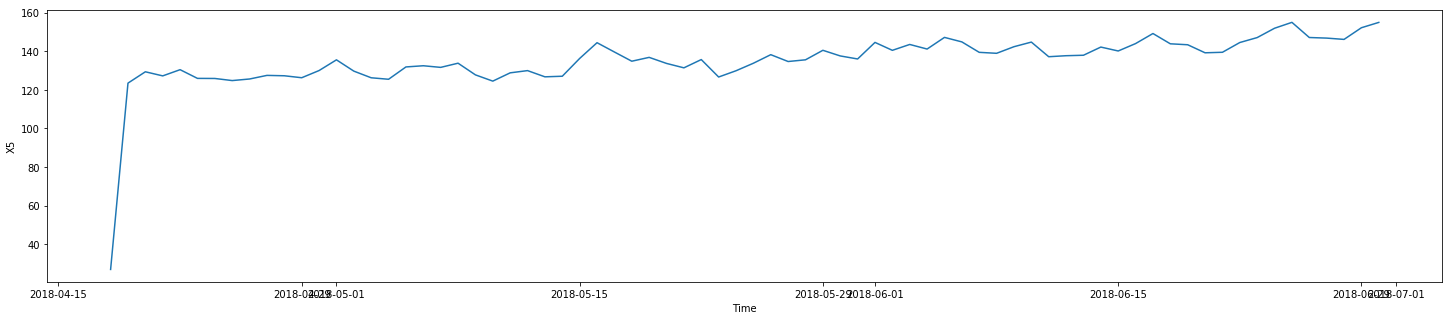

In [169]:
for col in sub['meter_id']:
    train_df = test[['Time', col]].fillna(-1)
    train_df['Time'] = pd.to_datetime(train_df['Time'])
    
    
    col_list = ['X5', 'X7', 'X10', 'X16', 'X18']
    
    if col in col_list:
        train_df = train_df[train_df[col]!=-1].reset_index(drop=True)
        train_df['Time'] = train_df['Time'].dt.date
        train_df = train_df.groupby('Time').sum().reset_index()
#         continue
#     elif col=='X20':
#         train_df = train_df[train_df[col]!=-1]
#         train_df[col] = train_df[col].clip(0, train_df[col].mean() + train_df[col].std()*.5)
#         train_df = train_df.loc[8148:].reset_index(drop=True)
#         continue
#     elif col=='X26':
#         train_df = train_df[train_df[col]!=-1].reset_index(drop=True)
#         train_df[col] = train_df[col].clip(0, train_df[col].mean() + train_df[col].std()*3)
    
    
    plt.figure(figsize=(25, 5))
    sns.lineplot(x='Time', y=col, data=train_df)
    plt.show()
    break

#### time series(SARIMA)

In [0]:
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
    return p_value

In [0]:
import warnings
warnings.filterwarnings('ignore')

save_target = defaultdict()

for col in tqdm.tqdm_notebook(sub['meter_id']):
    train_df = test[['Time', col]].dropna().reset_index(drop=True)
    train_df['Time'] = pd.to_datetime(train_df['Time'])
    
#     train_df['Time'] = train_df['Time'].dt.date
#     train_df = train_df.groupby('Time').sum().reset_index()
    
    train_df[col] = np.log1p(train_df[col])
    
#     test_df = train_df.iloc[-8:].reset_index(drop=True)
#     train_df = train_df.iloc[:-8].reset_index(drop=True)    
    
#     p_value = tsplot(train_df[col])
#     if p_value>0.01:
#         train_diff = train_df[col] - train_df[col].shift(7)
#         p_value = tsplot(train_diff[7:], lags=40)
#         if p_value>0.01:
#             train_diff = train_diff - train_diff.shift(1)
#             p_value = tsplot(train_diff[7+1:], lags=40)

    # setting initial values and some bounds for them
    ps = range(1, 3)
    d=1 
    qs = range(1, 3)
    Ps = range(0, 2)
    D=1 
    Qs = range(0, 2)
    s = 24 # season length is still 24

    # creating list with all the possible combinations of parameters
    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)
#     len(parameters_list)


    result_table = optimizeSARIMA(parameters_list, d, D, s)
    p, q, P, Q = result_table.loc[0, 'parameters']
    best_model=sm.tsa.statespace.SARIMAX(train_df[col], order=(p, d, q), 
                                            seasonal_order=(P, D, Q, s)).fit(disp=-1)

    forecast = plotSARIMA(train_df[[col]], best_model, 24)
    save_target[col] = forecast[-24:].values
    
    break

In [240]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/11dacon/submit/'
np.expm1(pd.DataFrame(save_target).T).to_csv(path+'sub_time_series_day.csv', index=False)

Mounted at /content/drive


In [0]:
# gradient boosting, groupby

In [181]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [0]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm.tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(train_df[col], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

optimizeSARIMA(parameters_list, d, D, s)

In [0]:
# set the parameters that give the lowest AIC
p, q, P, Q = (2, 3, 0, 0)#result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(train_df[col], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

In [0]:
tsplot(best_model.resid[24+1:], lags=40)

In [0]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
    return forecast
    
forecast = plotSARIMA(train_df[[col]], best_model, 7)